# Provenance

One aspect of data provenance is keeping track of the processing steps applied to data.

Next, we will learn how this can be done working with `xarray` objects.

In [1]:
import h5rdmtoolbox as h5tbx
import numpy as np

For the example, let's assume a 3D-velocity field with time, y- and x-dimension:

In [2]:
cv = h5tbx.conventions.from_zenodo('https://zenodo.org/record/8301535')

h5tbx.use(cv)

using("h5rdmtoolbox-tutorial-convention")

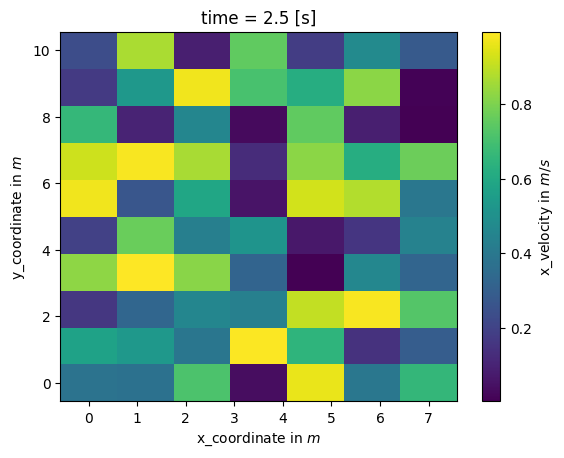

In [3]:
with h5tbx.File(data_type='experimental', contact=h5tbx.__author_orcid__) as h5:
    h5.create_dataset('time', data=np.linspace(0, 5, 5), standard_name='time', units='s', make_scale=True)
    h5.create_dataset('y', data=np.linspace(0, 10, 10), standard_name='y_coordinate', units='m', make_scale=True)
    h5.create_dataset('x', data=np.linspace(0, 7, 7), standard_name='x_coordinate', units='m', make_scale=True)
    h5.create_dataset('u', data=np.random.rand(5, 10, 7), standard_name='x_velocity', units='m/s', attach_scale=('time', 'y', 'x'))
    u = h5.u[:]

# plot t=2.5 s:
u.sel(time=2.5).plot()

In [4]:
from h5rdmtoolbox.conventions.standard_names import accessor

In [5]:
u_processed = u.snt[0:2,...].snt.arithmetic_mean_of(dim='time')

def get_dim_shape(da):
    return {d: len(da[d]) for d in da.dims}

def explain_history(da):
    for i, item in enumerate(da.attrs['PROVENANCE']['processing_history']):
        print(i, 'applied ', item['name'], ' on array with shape', item['parent']['dims_shape'])
        print('  -> ', item['name'])
    print('Current shape ', get_dim_shape(da))

explain_history(u_processed)

0 applied  __getitem__  on array with shape {'time': 5, 'y': 10, 'x': 7}
  ->  __getitem__
1 applied  arithmetic_mean_of  on array with shape {'time': 2, 'y': 10, 'x': 7}
  ->  arithmetic_mean_of
Current shape  {'y': 10, 'x': 7}
